<h3> Мобильное приложение продаж продуктов питания <a class="tocSkip"> </h3>

**Цель проекта:** отследить поведение пользователей приложения, построить воронку событий и оценить результаты A/A/B-теста.
    
**Входные данные:** Логи действий пользователей, то есть, события с привязкой к индентификатор:
    
    1) Название события;
    2) Уникальный идентификатор события;
    3) Время события;
    4) Группа эксперимента.
    
**Работа состоит из:**
* Загрузки данных, ознакомления с ними;
    
* Подготовки и предобработки данных, удаления дублируемой информации;
    
* Анализа и проверки данных;
    
* Изучения и составления воронки событий;
    
* Оценки результатов эксперимента A/A/B-теста.
    
*Проект подготовил: Мамаев П.Р.*

## Загрузка данных

### Импортируем необходимые для работы библиотеки

In [1]:
import pandas as pd
import scipy.stats as st
import datetime as dt
import math as mth
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

### Загрузим логи данных

In [2]:
log = pd.read_csv('/datasets/logs_exp.csv',  sep='\t')

### Изучим общую информацию

In [3]:
log.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [4]:
log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Изменим названия столбцов и переведём на нижний регистр.

Формат столбца с датой изменим на читабельный для человека. 

Всего у нас чуть более *244* тысяч записей.

## Подготовка и предобработка данных

### Изменение регистра и формата данных

In [5]:
log.columns = ['event_name', 'user_id', 'dt', 'group']
log['dt'] = pd.to_datetime(log['dt'], unit='s')

In [6]:
log.head()

,event_name,user_id,dt,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


Названия столбцов изменены, формат записи времени в `dt` также изменён.

### Поиск пропусков и дубликатов

In [7]:
log.isna().sum()

event_name    0
user_id       0
dt            0
group         0
dtype: int64

Пропуски отсутствуют, замечательно.

In [8]:
log.duplicated().sum()

413

Но, к сожалению, 413 записей дублируются. Однако, исходя из того, что записей у нас более 244 тысяч, 413 ничтожно малое число. Можем спокойно избавиться от них.

In [9]:
log = log.drop_duplicates()

### Добавление столбца с датой

Для удобства дальнейшей работы, добавим ещё один столбец с датой.

In [10]:
log['date'] = log['dt'].dt.date
log['date'] = pd.to_datetime(log['date'], format='%Y-%m-%d')
log.head()

,event_name,user_id,dt,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Отлично, теперь данные готовы и можно приступать к анализу.

### Вывод по п.2

Данные таблицы были успешно загружены, изучены и переведены в удобный для работы формат. Также был выполнен поиск пропусков и дубликатов в таблице. Пропуски отсутствовали, дублируемая информаци была удалена, добавили отдельный столбец с датой.

## Анализ и проверка данных

### Анализ данных

#### Количество событий в таблице

Так как в распоряжении мы имеем файл с логами событий, значит, каждая его строка и есть отдельно событие.


In [11]:
log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   dt          243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.2+ MB


Всего **243713** событий в таблице.

#### Количество пользователей в таблице

In [12]:
uniq_users = log['user_id'].nunique()
uniq_users

7551

**7551** уникальный пользователь в таблице на данный момент.

#### Среднее количество событий на пользователя

In [13]:
event_per_user = log.pivot_table(index='user_id', values='dt', aggfunc='count')
event_per_user.mean()

dt    32.275593
dtype: float64

Среднее количество событий на одного пользователя равно *32*.

#### Временной диапазон

Для начала, определим длительность теста, найдем минимальную и максимальную дату.

In [14]:
min_date = log['date'].min()
max_date = log['date'].max()
min_date, max_date

(Timestamp('2019-07-25 00:00:00'), Timestamp('2019-08-07 00:00:00'))

In [15]:
max_date - min_date

Timedelta('13 days 00:00:00')

Тест начался `25 июля 2019`, закончился `7 августа 2019`. Длился тест `13 дней`.

Теперь найдем распределение количества событий по дате в зависимости от группы эксперимента.

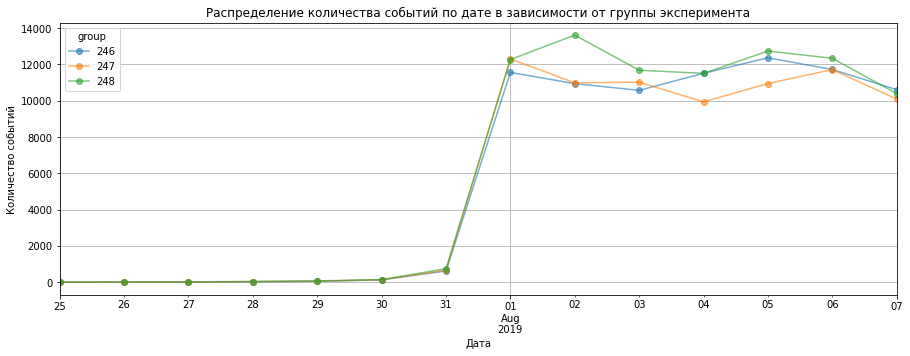

In [16]:
group_by_date = (
    log
    .pivot_table(index='date', columns='group', values='dt', aggfunc='count')
    .plot(grid=True, style='-o', figsize=(15, 5), alpha=0.6, legend=True,)
)
plt.title('Распределение количества событий по дате в зависимости от группы эксперимента')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

И графика видно, что в первую неделю событий минимальное количество, зато во второй половине теста их для каждой группы всегда более 10 тысяч. Проблема может быть в том, что события "доезжают" только позже из-за некоторых ошибок на сервере.

Ещё на графике видно, что экспериментальная группа 248 с другим шрифтом совершает больше других групп событий в течение периода работы теста.

Построим гистрограмму распределения количества событий по часам 31 июля.

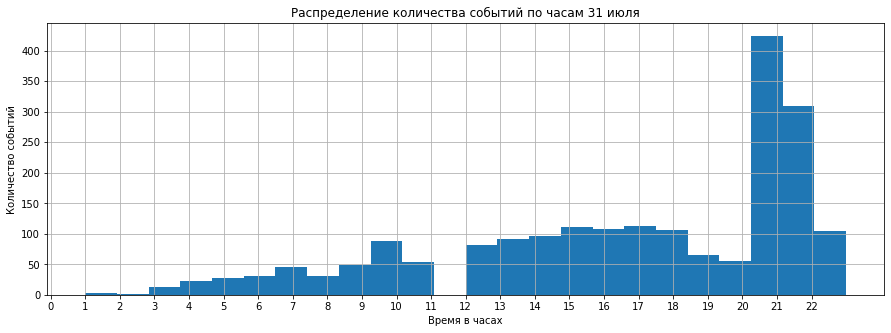

In [17]:
july_31 = log.query('date == "2019-07-31"')
july_31['dt'].dt.hour.hist(bins=24, figsize=(15, 5))
plt.xticks(range(0, 23))
plt.title('Распределение количества событий по часам 31 июля')
plt.xlabel('Время в часах')
plt.ylabel('Количество событий')
plt.show()

Из графика гистограммы видно, что бОльшее количество событий 31 июля приходится на ночное время.

Для сравнения, построим график распределения событий для 1 августа.

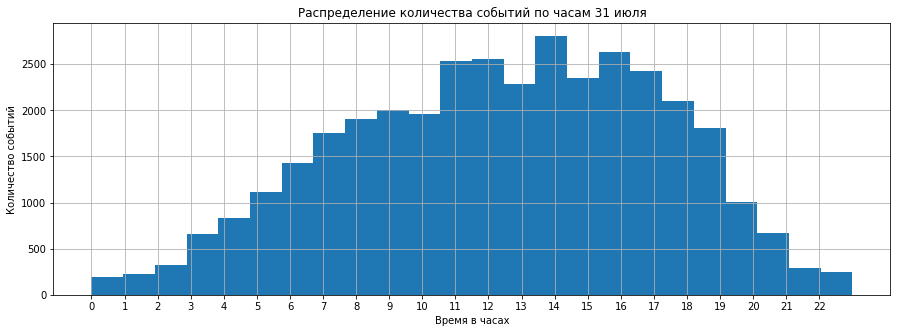

In [18]:
august_1 = log.query('date == "2019-08-01"')
august_1['dt'].dt.hour.hist(bins=24, figsize=(15, 5))
plt.xticks(range(0, 23))
plt.title('Распределение количества событий по часам 31 июля')
plt.xlabel('Время в часах')
plt.ylabel('Количество событий')
plt.show()

Тогда как для 1 августа основное количество событий приходится на дневное время суток. Данные за июль будут искажать основную информацию, потому именно от них лучше избавиться.

### Проверка данных

#### Количество потерянных данных

In [19]:
wasted_log = log.query("date <= '2019-07-31'") #занесли всю потерянную информацию в отдельную таблицу

In [20]:
wasted_log

,event_name,user_id,dt,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
2823,OffersScreenAppear,2413191300976302222,2019-07-31 23:54:55,247,2019-07-31
2824,MainScreenAppear,5505110279185484837,2019-07-31 23:57:30,247,2019-07-31
2825,MainScreenAppear,5505110279185484837,2019-07-31 23:57:42,247,2019-07-31
2826,MainScreenAppear,5505110279185484837,2019-07-31 23:57:52,247,2019-07-31


По итогу нашего среза мы потеряли 2826 событий. Сгруппируем их по событиям.

In [21]:
wasted_events = wasted_log.groupby('event_name').agg({'user_id':'count'}).rename(columns={'user_id':'event_cnt'})
wasted_events['wasted_ratio'] = (wasted_events['event_cnt'] / len(log) * 100).round(2)
wasted_events.sort_values(by='event_cnt', ascending=False)

,event_cnt,wasted_ratio
event_name,,
MainScreenAppear,1773,0.73
OffersScreenAppear,475,0.19
CartScreenAppear,365,0.15
PaymentScreenSuccessful,200,0.08
Tutorial,13,0.01


И большинство из них - cобытия, связанные с переходом на главный экран, *1773* подобных события. Меньше всего потеряли событий с *Руководством*. Добавили столбец с процентным отношением количества потерянных событий от общего числа событий. В сумме - чуть более одного процента всех событий.

Теперь посчитаем количество потерянных пользователей в абсолютных и относительных показателях.

In [22]:
users_cnt_before_slice = log['user_id'].nunique()
print('Количество пользователей до среза данных: ', users_cnt_before_slice)

log = log.query('date >= "2019-08-01"') #срезали ненужные данные для дальнешей работы

users_cnt_after_slice = log['user_id'].nunique()
print('Количество пользователей до среза данных: ', users_cnt_after_slice)
print('Количество потерянных пользователей: ', users_cnt_before_slice - users_cnt_after_slice)
print('Что составляет', "{0:.2f}".format((users_cnt_before_slice - users_cnt_after_slice) / users_cnt_before_slice * 100), '% от изначального числа пользователей')

Количество пользователей до среза данных:  7551
Количество пользователей до среза данных:  7534
Количество потерянных пользователей:  17
Что составляет 0.23 % от изначального числа пользователей


#### Количество пользователей из разных групп

In [23]:
grouped_users = (
    log
    .groupby('group')
    .agg({'user_id':'nunique'})
)
grouped_users

,user_id
group,
246,2484
247,2513
248,2537


Группы у нас примерно равны, наибольшая экспериментальная. Невозможно добиться идеального соотношения пользователей в группах в условиях реального эксперимента, потому наше максимальное отличие в чуть более 50 пользователей можем считать нормальным.

Теперь заново посчитаем общее количество уникальных пользователей.

In [24]:
uniq_users = log['user_id'].nunique()
uniq_users

7534

Как я и писал выше, после среза мы потеряли всего 17 пользователей. Нас это устраивает.

### Вывод по п. 3

* Событий в таблице столько же, сколько и строчек таблицы. Изначально 243713, теперь 240887.
* До среза у нас 7551 пользователь, после - 7434.
* Среднее количество событий на пользователя - 32.
* Тест проходил 13 дней, из которых половину времени почти никаких событий в таблицу не попадало. Скорее всего, это вызвано техническими проблемами. От пустого временного промежутка пришлось избавиться.

## Изучение воронки событий

### Частота событий

Сначала посчитаем сколько раз встречается определённое событие в логах.

In [25]:
event_freq = (
    log.groupby('event_name')
    .agg({'user_id':'count'})
    .sort_values(by='user_id', ascending=False)
    .rename(columns={'user_id':'event_cnt'})
)
event_freq

,event_cnt
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


### Частота событий по пользователям

Теперь посчитаем количество уникальных пользователей, которые совершали каждое из этих событий.

In [26]:
event_freq_per_user = (
    log
    .groupby('event_name')
    .agg({'user_id':'nunique'})
    .sort_values(by='user_id', ascending=False)
    .rename(columns={'user_id':'user_cnt'})
)
event_freq_per_user

,user_cnt
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


Далее найдём долю пользователей, которые хоть раз совершали событие. Разделим таблицу с частотой событий на количество уникальных пользователей. Умномножим на 100 для получения процентов и округлим результат.

In [27]:
event_share = (event_freq_per_user / uniq_users * 100).round(2).reset_index()
event_share

,event_name,user_cnt
0,MainScreenAppear,98.47
1,OffersScreenAppear,60.96
2,CartScreenAppear,49.56
3,PaymentScreenSuccessful,46.97
4,Tutorial,11.15


* 98% пользователей перешли на главную страницу;
* 61% пользователей просмотрели страницу с предложениями;
* 49% пользователей перешли в корзину;
* 47% пользователей дошли до страницы оплаты;
* И лишь 11% пользователей перешли на страницу с руководством.

По таблице с долями видно, как развивается воронка событий: 
    
    1) Сначала пользователь оказывается на главной странице;
    2) Затем он выбирает необходимые продукты и добавляет их в корзину;
    3) Далее переходит на страницу с корзиной, сверяется;
    4) Последним этапом является страница с успешной оплатой;
Руководство не является полноценным этапом воронки, так как пользователю может быть интуитивно понятно как пользоваться приложением, да и перейти на эту страницу можно с любого другого этапа.
По этой причине, в дальнейшем, не будем учитывать страницу с руководством.

In [28]:
log = log.query('event_name != "Tutorial"')
event_freq_per_user = event_freq_per_user.query('event_name != "Tutorial"')

### Доли пользователей на каждом этапе относительно предыдущего

Теперь найдем доли пользователей на каждом этапе относительно предыдущего этапа.

In [29]:
(event_freq_per_user / event_freq_per_user.shift() * 100).round(2)

,user_cnt
event_name,
MainScreenAppear,NaN
OffersScreenAppear,61.91
CartScreenAppear,81.30
PaymentScreenSuccessful,94.78


Распишу подробнее:
* Из 7534 уникального пользователя за время теста 98% перешли на главную страницу. Это мы знаем из предыдущего расчёта;
* Из тех 98% пользователей только 62% заходят на страницу с выбором продуктов;
* Далее, из тех, кто находился на странице с продуктами уже 81% процент переходили в корзину;
* И вот из тех 81% пользователей, которые уже находились в корзине, почти 95% успешно оплачивали заказ.

Этап с максимальным отсевом пользователей - это *страница с предожениями продуктов*.

Найдем количество пользователей, сделавших первый шаг и дошедших до конца воронки событий.

In [30]:
(event_freq_per_user.agg({'user_cnt': lambda x: x.min()/x.max()}) * 100).round(2)

user_cnt    47.7
dtype: float64

Более 47% пользователей из оказавшихся на главном экране по итогу оплачивает заказ.

Теперь визуализируем нашу воронку событий.

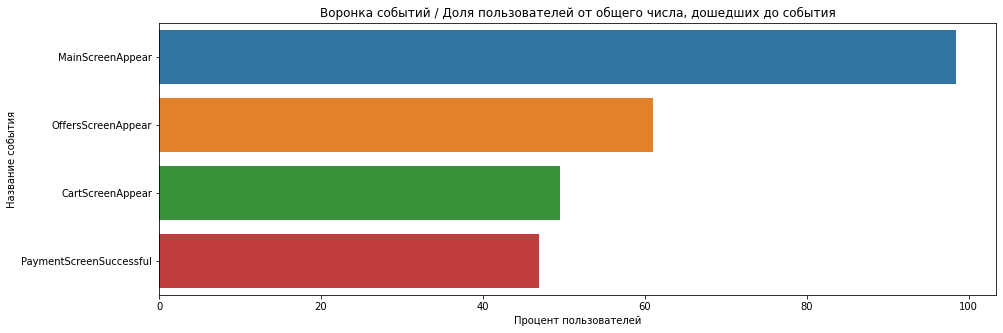

In [33]:
event_share = event_share.query('event_name != "Tutorial"')
plt.figure(figsize=(15, 5))
plt.title('Воронка событий / Доля пользователей от общего числа, дошедших до события')
sns.barplot(y=event_share['event_name'], x=event_share['user_cnt'])
plt.xlabel('Процент пользователей')
plt.ylabel('Название события')
plt.show()

### Вывод по п.4

Составили воронку событий, исключив события с руководством. Нашли количество пользователей для каждого этапа и относительно предыдущего этапа и визуализировали воронку событий.

* Воронка событий выглядит так: **MainScreenAppear → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful**. Событие **Tutorial** стоит отдельно и не включается в воронку событий, поэтому на дальнейшем этапе оценки результатов эксперимента учитываться не будет.
* Более 47% пользователей приложения доходят до успешной оплаты заказа.
* Наибольшее количество пользователей отсеивается на этапе перехода с главной страницы на страницу выбора продуктов.

## Оценка результатов эксперимента A/A/B-теста

### Количество пользователей в каждой группе

In [36]:
groups_size = (
    log
    .groupby('group')
    .agg({'user_id':'nunique'})
    .sort_values(by='user_id', ascending=False)
    .rename(columns={'user_id':'user_cnt'})
)
groups_size

,user_cnt
group,
248,2535
247,2512
246,2483


Теперь проверим пересечение пользователей по группам.

In [38]:
cnt_246 = log[log['group']==246]['user_id'].nunique()
cnt_247 = log[log['group']==247]['user_id'].nunique()
cnt_248 = log[log['group']==248]['user_id'].nunique()

print('Число уникальных пользователей контрольной группы  246:', cnt_246)
print('Число уникальных пользователей контрольной группы  247:', cnt_247)
print('Число уникальных пользователей экспериментальной группы 248:', cnt_248)
print('Сумма уникальных пользователей трёх групп:', (cnt_246 + cnt_247 + cnt_248))
print('Число уникальных пользователей трёх групп:', log['user_id'].nunique())

Число уникальных пользователей контрольной группы  246: 2483
Число уникальных пользователей контрольной группы  247: 2512
Число уникальных пользователей экспериментальной группы 248: 2535
Сумма уникальных пользователей трёх групп: 7530
Число уникальных пользователей трёх групп: 7530


Существует пересечение пользователей, но его нельзя назвать большим. 7 человек из 7530. Дальнейшей работе это не помешает.

### Статистический критерий контрольных групп A/A

Сначала проверим корректность расчётов между двумя контрольными группами - 246 и 247. Узнаем, есть ли в статистическом критерии разница между выборками данных групп.
Ограничим нашу выборку двумя группами.

In [40]:
group_246 = (
    log
    .query('group == 246')
)

group_247 = (
    log
    .query('group == 247')
)

Сгруппировали данные по группам и будем сравнивать число дошедших с первого этапа до последнего относительно групп.
Сформулируем гипотезы, на которые проверяем данные выборки:
* Нулевая гипотеза: между пропорциями выборок двух контрольных групп нет разницы.
* Альтернативная гипотеза: между пропорциями выборок двух контрольных групп есть разница.

In [41]:
alpha = 0.05  # критический уровень статистической значимости

#последний этап воронки
last_event = np.array([group_246[group_246['event_name']=='PaymentScreenSuccessful']['user_id'].nunique(), group_247[group_247['event_name']=='PaymentScreenSuccessful']['user_id'].nunique()])
#первый этап воронки
first_event = np.array([group_246[group_246['event_name']=='MainScreenAppear']['user_id'].nunique(), group_247[group_247['event_name']=='MainScreenAppear']['user_id'].nunique()])

p1 = last_event[0]/first_event[0]
p2 = last_event[1]/first_event[1]

p_combined = (last_event[0] + last_event[1]) / (first_event[0] + first_event[1])
difference = p1 - p2

z_value = difference / mth.sqrt(p_combined * (1- p_combined) * (1/first_event[0] + 1/first_event[1]))

distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между пропорциями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными'
    )

p-значение:  0.12044299485641763
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


Наш полученный критерий статистической значимости более чем в 2 раза выше критического уровня статистической значимости, что означает, что нулевая гипотеза о равенстве не может быть отвергнута, пропорции равны.

### Статистическая разница контрольных групп по событиям

Теперь, используя сформированные на прошлом этапе выборки, найдем критерий статистической разницы отношения самого популярного события в группе к общему числу пользователей группы.

Исходя из прошлых пунктов, мы знаем, что наиболее популярный этап у пользователей это **главная страница** или **MainScreenAppear**.
Гипотезы, на которые проверяем данные выборки:
* Нулевая гипотеза: между пропорциями выборок двух контрольных групп нет разницы.
* Альтернативная гипотеза: между пропорциями выборок двух контрольных групп есть разница.

In [42]:
alpha = 0.05  # критический уровень статистической значимости

#Число пользователей на самом популярном событии воронки
main_page = np.array([group_246[group_246['event_name']=='MainScreenAppear']['user_id'].nunique(), group_247[group_247['event_name']=='MainScreenAppear']['user_id'].nunique()])
#Общее число пользователей в группе
user_cnt = np.array([group_246['user_id'].nunique(), group_247['user_id'].nunique()])

p1 = main_page[0]/user_cnt[0]
p2 = main_page[1]/user_cnt[1]

p_combined = (main_page[0] + main_page[1]) / (user_cnt[0] + user_cnt[1])
difference = p1 - p2

z_value = difference / mth.sqrt(p_combined * (1- p_combined) * (1/user_cnt[0] + 1/user_cnt[1]))

distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между пропорциями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными'
    )

p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


При расчёте статистической значимости контрольных групп по самому популярному событию было выяснено, что `p_value` в 10 раз выше критического уровня статистической значимости, оснований отвергать нулевую гипотезу - нет.

Далее, найдем статистическую разницу по обеим контрольным группам уже по каждому событию в разрезе общего числа пользователей группы. Обернём всё это в функцию. Но перед этим, продублируем гипотезы:
* Нулевая гипотеза: между пропорциями выборок двух групп нет разницы.
* Альтернативная гипотеза: между пропорциями выборок двух групп есть разница.

In [43]:
def stat_difference(t1, t2, event_name):
    alpha = 0.05  # критический уровень статистической значимости

    #Число пользователей события воронки
    event_page = np.array([t1[t1['event_name']==event_name]['user_id'].nunique(), t2[t2['event_name']==event_name]['user_id'].nunique()])
    #Общее число пользователей в группе
    user_cnt = np.array([t1['user_id'].nunique(), t2['user_id'].nunique()])

    p1 = event_page[0]/user_cnt[0]
    p2 = event_page[1]/user_cnt[1]

    p_combined = (event_page[0] + event_page[1]) / (user_cnt[0] + user_cnt[1])
    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1- p_combined) * (1/user_cnt[0] + 1/user_cnt[1]))

    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('Событие: ', event_name)
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между пропорциями есть значимая разница\n')
    else:
        print( 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными\n')

In [44]:
event_names = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
for i in event_names:
    stat_difference(group_246, group_247, i)

Событие:  MainScreenAppear
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными

Событие:  OffersScreenAppear
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными

Событие:  CartScreenAppear
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными

Событие:  PaymentScreenSuccessful
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными



Теперь мы можем с точностью утверждать, что статистической разницы между контрольными группами нет. Значит, **разбиение на контрольные группы происходит корректно**.

### Статистическая разница экспериментальной и контрольных групп по событиям

Чтобы сравнить статистическую разницу между экспериментальной и контрольной группой, сначала сформируем переменную с экспериментальной группой, а затем уже "прогоним" её вместе с каждой из контрольных групп по отдельности.

In [45]:
group_248 = (
    log
    .query('group == 248')
)

#### Сравнение экспериментальной 248 группы с контрольной 246 группой

* Нулевая гипотеза: между пропорциями выборок экспериментальной и контрольной групп нет разницы.
* Альтернативная гипотеза: между пропорциями выборок экспериментальной и контрольной групп есть разница.

In [46]:
for i in event_names:
    stat_difference(group_246, group_248, i)

Событие:  MainScreenAppear
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными

Событие:  OffersScreenAppear
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными

Событие:  CartScreenAppear
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными

Событие:  PaymentScreenSuccessful
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными



Функция не нашла статистической разницы между экспериментальной группой 248 и контрольной группой 246 ни по одному из событий.

#### Сравнение экспериментальной 248 группы с контрольной 247 группой

* Нулевая гипотеза: между пропорциями выборок экспериментальной и контрольной групп нет разницы.
* Альтернативная гипотеза: между пропорциями выборок экспериментальной и контрольной групп есть разница.

In [47]:
for i in event_names:
    stat_difference(group_247, group_248, i)

Событие:  MainScreenAppear
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными

Событие:  OffersScreenAppear
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными

Событие:  CartScreenAppear
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными

Событие:  PaymentScreenSuccessful
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными



Функция не нашла статистической разницы между экспериментальной группой 248 и контрольной группой 247 ни по одному из событий.

#### Сравнение экспериментальной 248 группы с объединённой контрольной группой

Сначала создадим объединенную переменную с двумя контрольными группами.

In [48]:
union_group = pd.concat([group_246, group_247])

* Нулевая гипотеза: между пропорциями выборок экспериментальной и объединенной контрольной группой нет разницы.
* Альтернативная гипотеза: между пропорциями выборок экспериментальной и объединенной контрольной группой есть разница.

In [49]:
for i in event_names:
    stat_difference(union_group, group_248, i)

Событие:  MainScreenAppear
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными

Событие:  OffersScreenAppear
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными

Событие:  CartScreenAppear
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными

Событие:  PaymentScreenSuccessful
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными



И тут функция не нашла статистической разницы между экспериментальной группой 248 и объединенными контрольными группами ни по одному из событий, значит, можно сделать вывод, что изменение шрифта не повлияло на пользователей никак.

### Выбор статистической значимости

Выбор значения `alpha = 0.05` обусловлен балансом между значимостью и мощностью. Исходя из теории, вероятность допустить ошибку первого рода равна уровню `alpha`. При уровне значимости в `0.1` мы имеем шанс в **10%** получить ложнопозитивный результат теста. По моему мнению, выбирая значения `alpha` между `0.01`, `0.05` и `0.1`, в данном случае имеет смысл остановить выбор на `0.05`, так как это самый сбалансированный вариант.

Даже при условии, что наш выбор пал бы на уровень статистической значимости равный `0.1`, все нулевые гипотезы всё равно нельзя было бы отвергнуть, так как все наши значения `p-value` больше `0.1`.

### Вывод по п.5

В данном пункте мы оценивали результаты A/A/B-теста и считали статистическую разницу между тремя группами пользователей.
* Количество пользователей:
    
    1) Экспериментальная группа 248	состоит из 2538 пользователей;
    
    2) Контрольная группа 247 состоит из 2519 пользователей;
    
    3) Контрольная группа 246 состоит из 2486 пользователей.
    
    
* Статистический критерий контрольных групп, то есть, A/A-тест показал нам, что эти группы поделены между собой в равной степени и разницы между ними нет.
* Также, как и нет оснований отвергать гипотезу о том, что экспериментальная группа и контрольные группы (вместе и по отдельности) равны.
* Размер критического уровеня статистической значимости был выбран как `0.05`, что означает, что мы можем допустить ошибку первого рода в одном (1) из двадцати (20) тестов. Нами было произведено 18 тестов.
* Из всего вышесказанного можно сделать вывод, что изменения шрифта никак не повлияло на пользователей.

## Общий вывод

Входными данными в задании были логи с действиями пользователей. 
В проекте были осуществены такие пункты:
* Загрузка и изучение данных. Было выяснено, что в изначальной таблице *244125* записей событий, привязанных к пользователю и дате с временем.
* В ходе подготовки и предобработки данных были изменены регистр и формат записи данных. В ходе поиска пропусков проблем не обнаружилось, в ходе поиска дубликатов - 413 дублируемых строчек. Добавили столбец с одной датой события.
* Во время анализа и проверки данных было найдено количество уникальных пользователей - *7551*, среднее число событий, равное *32* на одного пользователя. Также, в ходе выбора временного диапазона было обнаружено, что почти половину A/A/B-теста фактически никаких данных в таблицу не загружалось, что я могу связать с ошибкой на сервере записи. *Рекомендую в дальнейшем обратить внимание на данную проблему*. По итогу, почти неделю данных пришлось срезать в которых было *384* записи.
* В ходе изучения воронки событий была составлена таблица событий по частоте повторения, а также, таблица с частотой событий на одного пользователя. По итогам составления цепочки воронки событий было выяснено, что больше всего пользователей теряется на этапе перехода с *Главной страницы* на *Страницу с выбором товаров*. Также, на данном этапе избавились от событий, связанных с переходом на страницу с *Руководством*, так как она не является звеном воронки событий.
* По итогам оценки результатов эксперимента A/A/B-теста было выявлено, что группы статистически значимой разницы между группами нет и изменение шрифта никак не повлияло на пользователей. Было произведено 18 тестов. Уровень статистической значимости ни разу не был ниже критического уровня статистической значимости.